# Energy consumption

# Energy consumption notebook

This Jupyter Notebook reads data for
1. Energy consumption
2. Water consumption
3. Oil consumption
from a Google Sheet.
The numbers in the sheet get updated on a monthly base.
The Juypter Notebook analyses this data and creates several visualisation to let us see the consumption compared on a yearly, monthly base and how it develops over time.

## ToDos
- [ ] prognose der Restlaufzeit mit derzeitigem Ölstand
- [ ] overview with the total energy consumption per year
- [ ] values in the plotbox for meridian and others

In [14]:
# import required libraries pandas, numpy, matplotlib, seaborn, datetime
from __future__ import print_function

import os.path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import quickstart as qs
import locale


## General definitions


In [15]:
locale.setlocale(locale.LC_ALL, 'de_DE')

'de_DE'

## Read data from Google spreadsheet

In [16]:
# get a list of values for power, water and oil consumption from google sheets
values = qs.google_read_energy_power()
#convert list of values to pandas dataframe; first row is the header
#initially, df has the following columns: 'Strom (kwH)', 'Wasser (l)', 'Öl (l)', 'Monat', 'Jahr'
df = pd.DataFrame(values[1:], columns=values[0])

# Analyse the data

In [17]:
# print out the dimensions of the dataframe df
print(df.shape)
df.replace('', np.nan, inplace=True)
# check, how many cells per column do have invalid data
print(df.isnull().sum())

(122, 5)
Strom (kwH)      1
Wasser (l)       1
Öl (l)         122
Monat            0
Jahr             0
dtype: int64


## Set create working dataframe and set column types


In [20]:
# define a new working dataframe as a copy of df
df_new = df.copy()
# change the headers of the columns in df_new
df_new.columns = ['power', 'water', 'oil', 'month', 'year']
# set type of values in column 'power' to float
df_new['power'] = df_new['power'].astype(float)
# iterate over values in column 'power' until we find np.nan
for i in range(len(df_new['power'])):
    if np.isnan(df_new['power'][i]):
        #get the value from previous row and from next row
        power_mean_value = (df_new['power'][i-1] + df_new['power'][i+1])/2
        #locate the item, using .loc, in the dataframe in column power and replace it with the mean value
        df_new.loc[i, 'power'] = power_mean_value
# add a new column 'power_per_month' to df_new, where the values are the differences of the values in column 'power'
df_new['power_per_month'] = df_new['power'].diff()

df_new['water'] = df_new['water'].astype(float)
for i in range(len(df_new['water'])):
    if np.isnan(df_new['water'][i]):
        #get the value from previous row and from next row
        power_mean_value = (df_new['water'][i-1] + df_new['water'][i+1])/2
        #locate the item, using .loc, in the dataframe in column power and replace it with the mean value
        df_new.loc[i, 'water'] = power_mean_value
# add a new column 'water_per_month' to df_new, where the values are the differences of the values in column 'water'
df_new['water_per_month'] = df_new['water'].diff()

# add a new column 'date', which is the concatenation of the values in column 'month' and 'year'
df_new['date'] = df_new['month'] + '.' + df_new['year']
# convert the values in column 'date' (%B.%Y) to datetime format, where day is the last day of the month
df_new['date'] = pd.to_datetime(df_new['date'], format='%B.%Y')
# set the day of the timestamp in column 'date' to the last day of the month
df_new['date'] = df_new['date'] + pd.offsets.MonthEnd(0)

#df_new['month'] = df_new['month'].replace({'Januar':0, 'Februar':1, 'März':2, 'April':3, 'Mai':4, 'Juni':5, 'Juli':6,'August':7, 'September':8, 'Oktober':9, 'November':10, 'Dezember':11})
#make df_new['month'] categorical
df_new['month'] = df_new['month'].astype('category')
months = ["Januar", "Februar", "März", "April", "Mai", "Juni", 
          "Juli", "August", "September", "Oktober", "November", "Dezember"]
df_new['month'] = pd.Categorical(df_new['month'], categories=months, ordered=True)

Exclude the Outliers in a Column

In [21]:
lower = df_new.water_per_month.quantile(.05)
upper = df_new.water_per_month.quantile(.95)

df_new.water_per_month = df_new.water_per_month.clip(lower=lower, upper=upper)

## Show power consumption over time

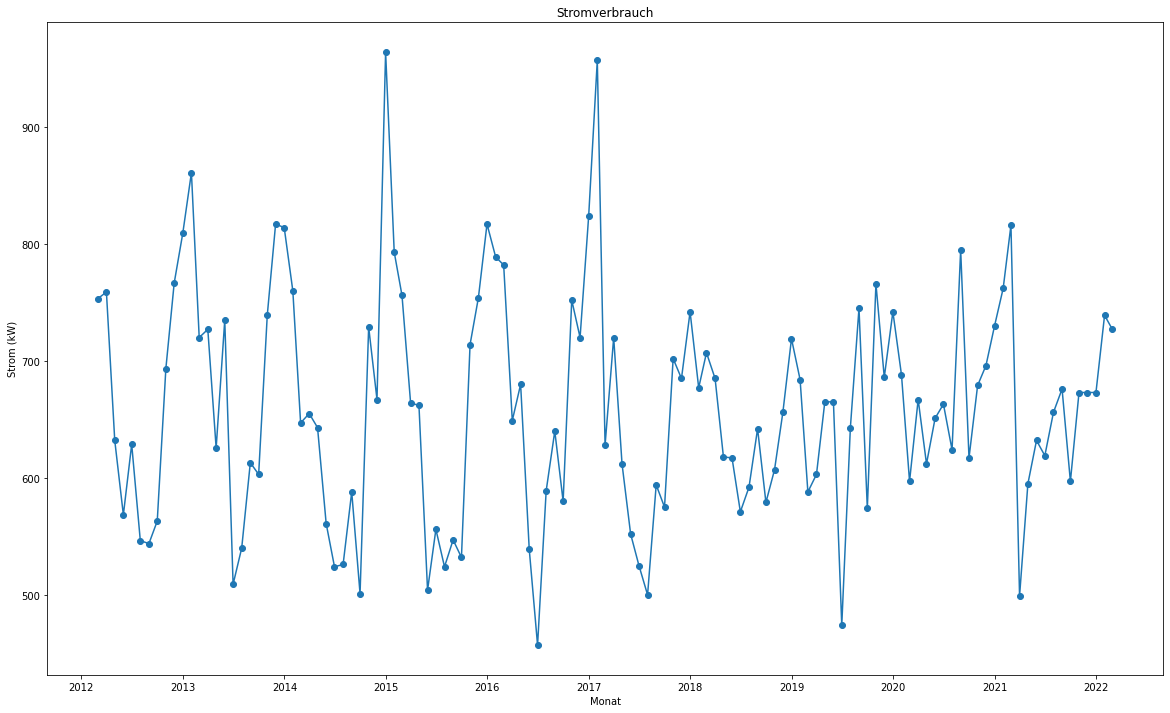

In [22]:
# draw a diagram that shows the power consumption per month
# create a new figure
fig = plt.figure(figsize=(20, 12))
# add a subplot (1 row, 1 column, 1st plot)
ax = fig.add_subplot(1, 1, 1)
# plot the data for the month in 2017
#ax.plot(df_new.loc[df_new['year'] == '2017', 'month'], df_new.loc[df_new['year'] == '2017', 'power_per_month'], 'o')
ax.plot(df_new['date'], df_new['power_per_month'], 'o-')
# set the x-axis label
ax.set_xlabel('Monat')
# set the y-axis label
ax.set_ylabel('Strom (kW)')
# set the title
ax.set_title('Stromverbrauch')
# show the plot
plt.show()


## Show water consumption per month

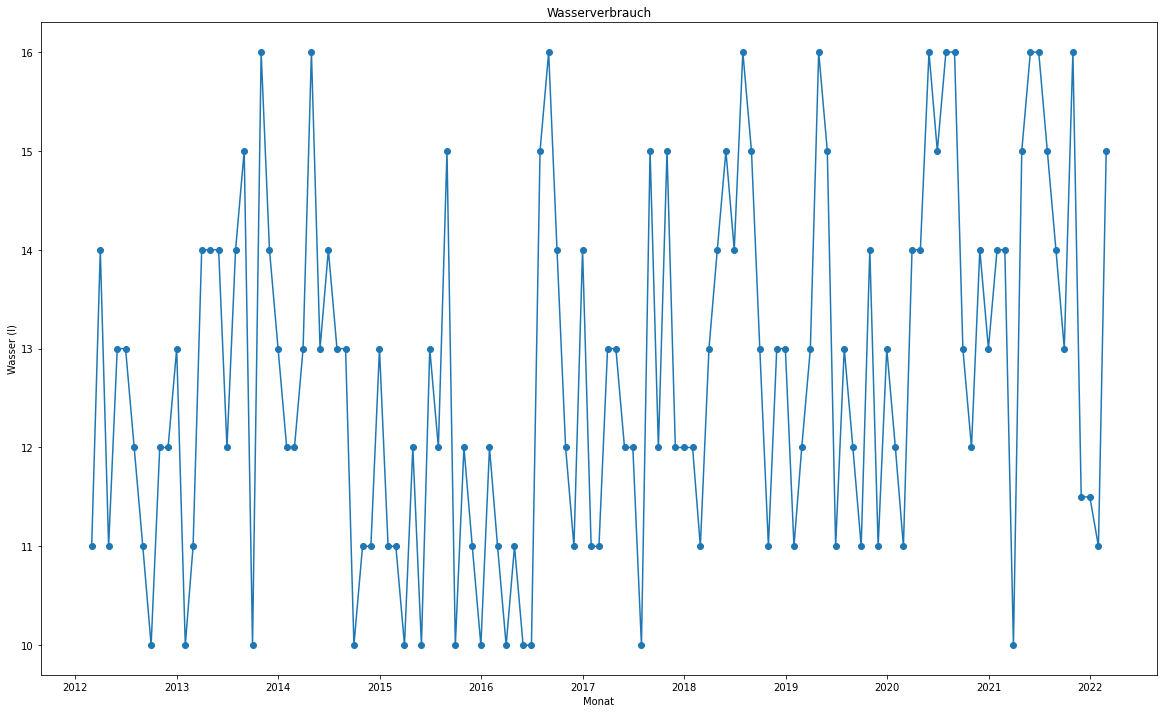

In [23]:
# draw a diagram that shows the power consumption per month
# create a new figure
fig = plt.figure(figsize=(20, 12))
# add a subplot (1 row, 1 column, 1st plot)
ax = fig.add_subplot(1, 1, 1)
# plot the data for the month in 2017
#ax.plot(df_new.loc[df_new['year'] == '2017', 'month'], df_new.loc[df_new['year'] == '2017', 'power_per_month'], 'o')
ax.plot(df_new['date'], df_new['water_per_month'], 'o-')
# set the x-axis label
ax.set_xlabel('Monat')
# set the y-axis label
ax.set_ylabel('Wasser (l)')
# set the title
ax.set_title('Wasserverbrauch')
# show the plot
plt.show()


## A Boxplot, that shows the minimum and maximum values of energy consumption per month

<AxesSubplot:title={'center':'power_per_month'}, xlabel='month'>

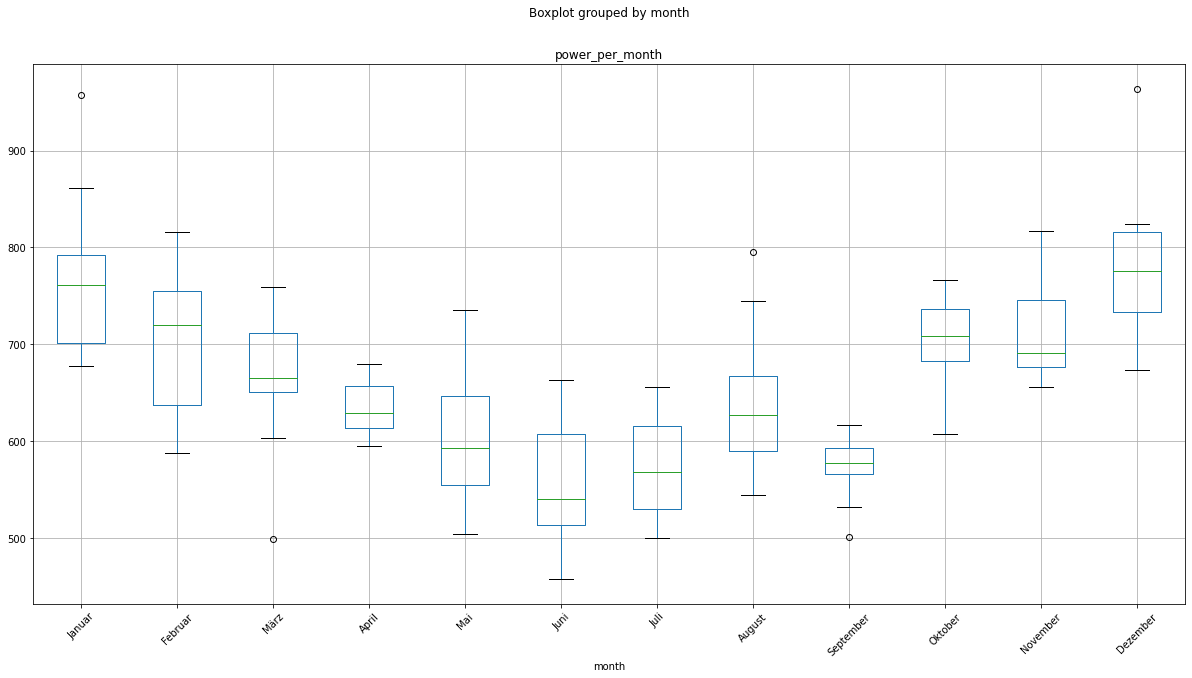

In [24]:
df_new.boxplot(by='month', column =['power_per_month'], grid = True, rot=45, figsize=(20,10))


## A Boxplot, that shows the minimum and maximum values of water consumption per month

<AxesSubplot:title={'center':'water_per_month'}, xlabel='month'>

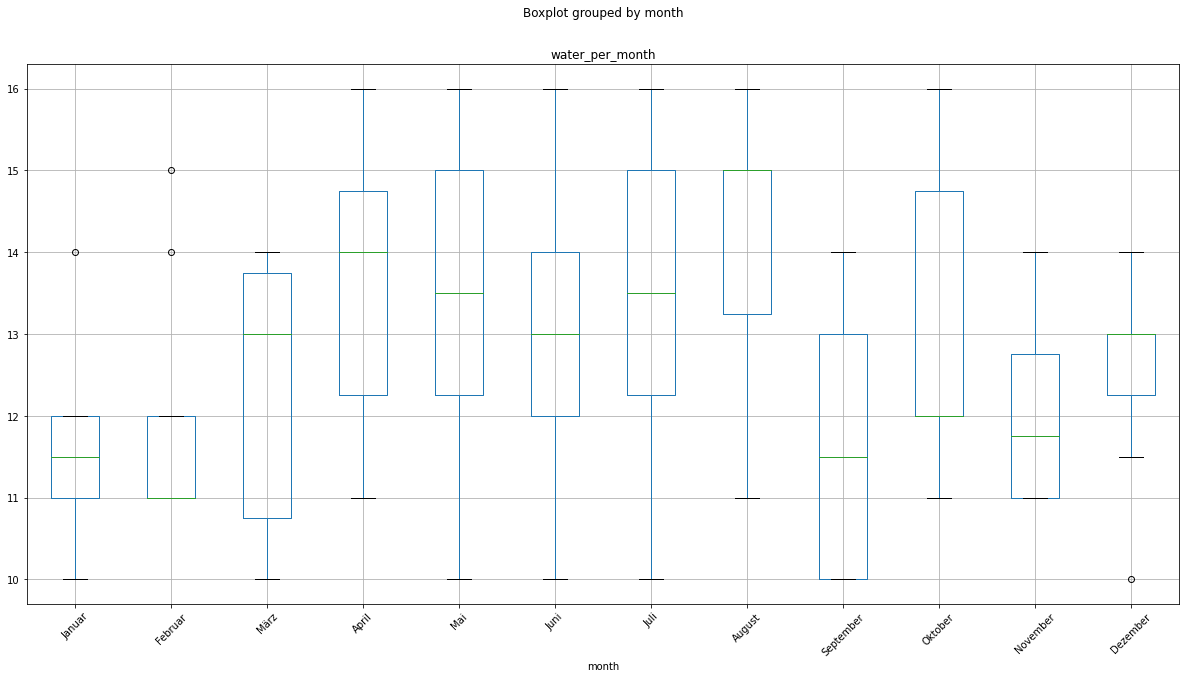

In [25]:
df_new.boxplot(by='month', column =['water_per_month'], grid = True, rot=45, figsize=(20,10))


## Heatmap for the energy consumption per month

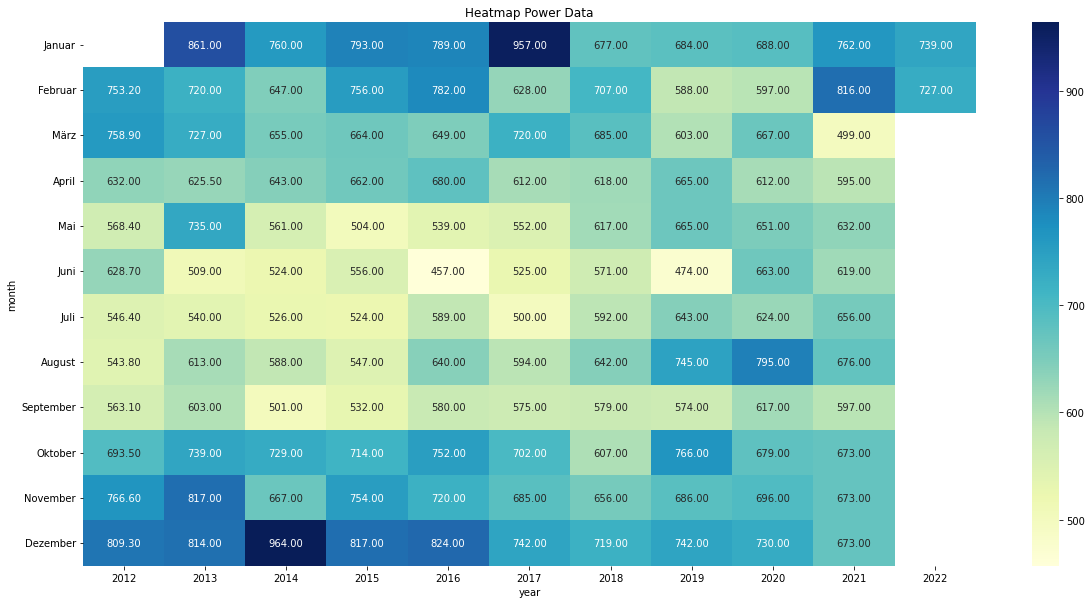

In [26]:
df_heatmap = df_new.pivot(index='month', columns='year', values='power_per_month')
#define the size of the heatmap as width=20 inches and height=10 inches
fig = plt.figure(figsize=(20,10))
ax = sns.heatmap(df_heatmap, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title("Heatmap Power Data")
plt.show()

## Heatmap for the water consumption per month

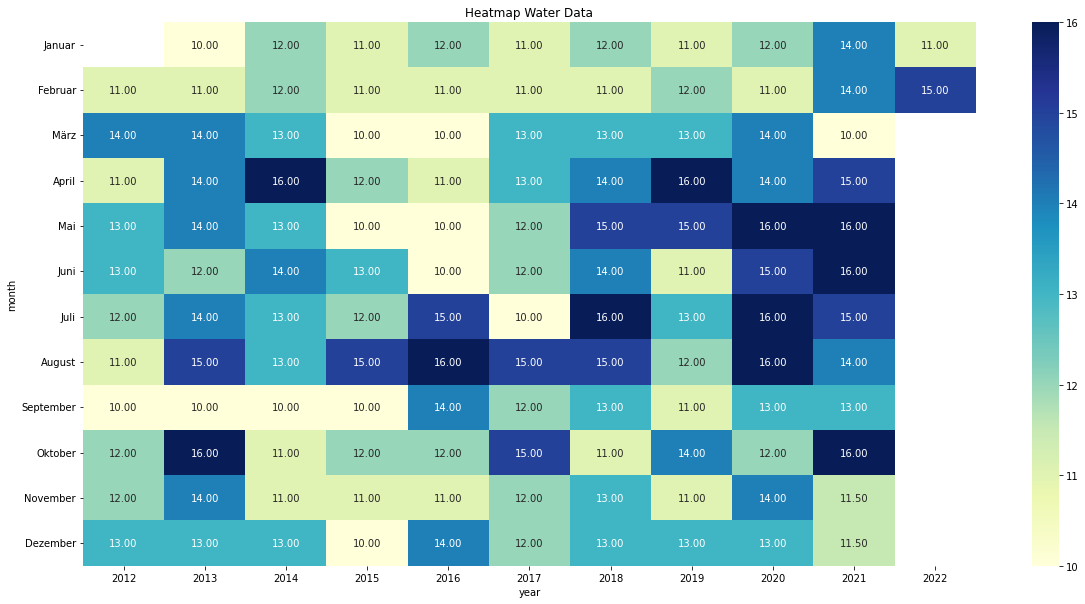

In [27]:
df_heatmap = df_new.pivot(index='month', columns='year', values='water_per_month')
#define the size of the heatmap as width=20 inches and height=10 inches
fig = plt.figure(figsize=(20,10))
ax = sns.heatmap(df_heatmap, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title("Heatmap Water Data")
plt.show()

## Power consumption per year

In [11]:
# print out a table with the total power consumption (power_per_momth) per year
print(df_new.groupby('year')['power_per_month'].sum())
#print(df_new.groupby('year').sum('power_per_month'))


year
2012    7263.9
2013    8303.5
2014    7765.0
2015    7823.0
2016    8001.0
2017    7792.0
2018    7670.0
2019    7835.0
2020    8019.0
2021    7871.0
2022    1466.0
Name: power_per_month, dtype: float64


## Water consumption per year

In [28]:
# print out a table with the total power consumption (power_per_momth) per year
print(df_new.groupby('year')['water_per_month'].sum())
#print(df_new.groupby('year').sum('power_per_month'))


year
2012    132.0
2013    157.0
2014    151.0
2015    137.0
2016    146.0
2017    148.0
2018    160.0
2019    152.0
2020    166.0
2021    166.0
2022     26.0
Name: water_per_month, dtype: float64
